This is an implementation of the *harder* option for Assignment 3 of coursera's [Applied Plotting, Charting & Data Representation in Python](https://www.coursera.org/learn/python-plotting/home/welcome).


# Description

A challenge that users face is that, for a given y-axis value (e.g.
42,000), it is difficult to know which x-axis values are most likely to
be representative, because the confidence levels overlap and their
distributions are different (the lengths of the confidence interval bars
are unequal). One of the solutions the authors propose for this problem
(Figure 2c) is to allow users to indicate the y-axis value of interest
(e.g. 42,000) and then draw a horizontal line and color bars based on
this value. So bars might be colored red if they are definitely above
this value (given the confidence interval), blue if they are definitely
below this value, or white if they contain this value.

*Even Harder option:* Add interactivity to the above, which allows the
user to click on the y axis to set the value of interest. The bar colors
should change with respect to what value the user has selected.

# Imports

All the imports were created by third-parties (taken from pypi).



In [8]:
import matplotlib.pyplot as pyplot
import numpy
import pandas
import scipy.stats as stats
import seaborn


# Some Plotting Setup



In [9]:
%matplotlib notebook
style = seaborn.axes_style("whitegrid")
style["axes.grid"] = False
seaborn.set_style("whitegrid", style)


# The Data

There data set will be four normally-distributed, randomly generated data sets each representing a simulated data set for a given year.


## `numpy.random.normal`

This is from the `numpy.random.normal` doc-string:

`normal(loc=0.0, scale=1.0, size=None)`

Draw random samples from a normal (Gaussian) distribution.

The probability density function of the normal distribution, first
derived by De Moivre and 200 years later by both Gauss and Laplace
independently [2]\_, is often called the bell curve because of
its characteristic shape (see the example below).

The normal distributions occurs often in nature.  For example, it
describes the commonly occurring distribution of samples influenced
by a large number of tiny, random disturbances, each with its own
unique distribution.


## Parameters


### `loc` : float or array\_like of floats

Mean ("centre") of the distribution.


### `scale` : float or array\_like of floats

Standard deviation (spread or "width") of the distribution.


### `size` : int or tuple of ints, optional

Output shape.  If the given shape is, e.g., `(m, n, k)`, then
`m * n * k` samples are drawn.  If size is `None` (default),
a single value is returned if `loc` and `scale` are both scalars.
Otherwise, `np.broadcast(loc, scale).size` samples are drawn.



In [10]:
numpy.random.seed(12345)

data = pandas.DataFrame([numpy.random.normal(33500,150000,3650), 
                         numpy.random.normal(41000,90000,3650), 
                         numpy.random.normal(41000,120000,3650), 
                         numpy.random.normal(48000,55000,3650)], 
                        index=[1992,1993,1994,1995])

In [11]:
data.T.describe()

,1992,1993,1994,1995
count,3650.000000,3650.000000,3650.000000,3650.000000
mean,34484.080607,39975.673587,37565.689950,47798.504333
std,150473.176164,88558.520583,120317.078777,54828.074297
min,-528303.381600,-287127.421315,-382709.382654,-138894.685422
25%,-67555.298773,-21665.471992,-45516.912051,11680.007981
50%,31756.198287,41001.778992,39197.241173,49103.396625
75%,135081.379021,99766.920131,121367.183244,84271.976610
max,622629.206119,358327.854561,423792.855746,262363.983464


Comparing the sample to the values fed to the `normal` function it appears that even with 3,650 values, it's still not exactly what we asked for.

<IPython.core.display.Javascript object>


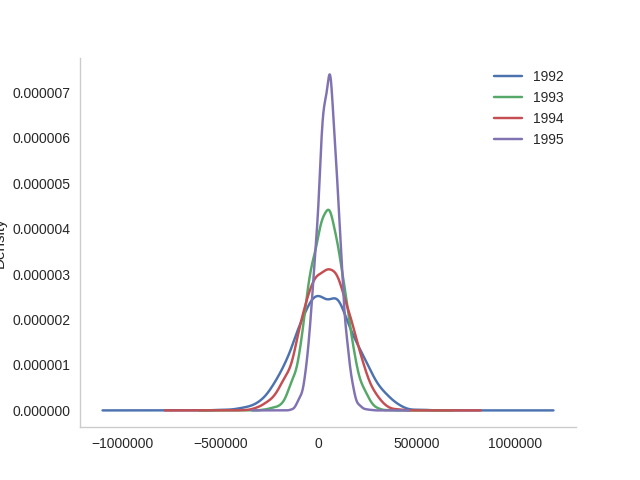

In [12]:
data.T.plot.kde()
seaborn.despine()

1992, the plot with the largest spread looks kind of lumpy. Their means look surprisingly close, but that's probably because the large standaard deviation distorts the scale.



<IPython.core.display.Javascript object>


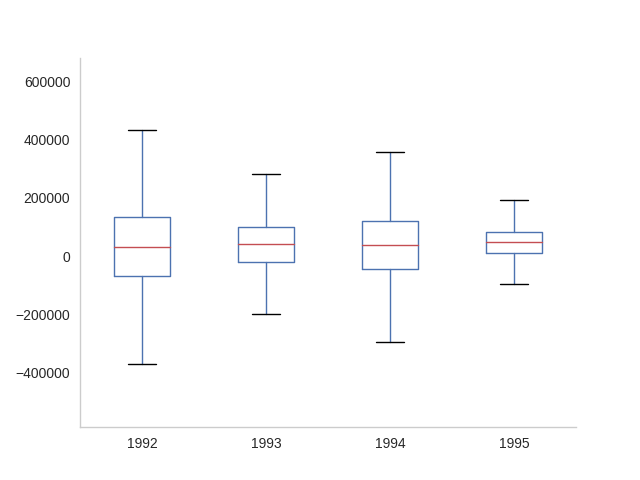

In [13]:
data.T.plot.box()
seaborn.despine()

The box-plot shows once again that there centers are relatively close. But 1992 and 1994 have considerably more spread than 1993 and especially more than 1995.


# Interval Check

This is the class that implements the plotting. It colors the bar-plots based on whether the value given is within a bar's confidence interval (white), below the confidence interval (blue) or above the confidence interval (red). It's set up to work with the easiest case so the `color_bars` method has to be overridden to make it work for this case.



In [18]:
class IntervalCheck(object):
    """colors plot based on whether a value is in range
    Args:
     data (DataFrame): frame with data of interest as columns
     confidence_interval (float): probability we want to exceed
    """
    def __init__(self, data, confidence_interval=0.95, title="Confidence Intervals"):
        self.data = data
        self.confidence_interval = confidence_interval
        self.title = title
        self._intervals = None
        self._lows = None
        self._highs = None
        self._errors = None
        self._means = None
        self._errors = None
        self._figure = None
        self._axes = None
        self._bars = None
        self.horizontal_line = None
        self.line_label = None
        return
    
    @property
    def figure(self):
        if self._figure is None:
            """A pyplot figure"""
            self._figure = pyplot.figure()
        return self._figure
    
    @property
    def axes(self):
        if self._axes is None:
            """the current axes for self.figure"""
            self._axes = self.figure.gca()
            self._axes.set_title(self.title)
        return self._axes
    
    @property
    def bars(self):
        """the bar-plot-objects"""
        if self._bars is None:
            self._bars = self.axes.bar(self.data.columns, self.means, 
                                       yerr=self.errors)
        return self._bars

    @property
    def intervals(self):
        """list of high and low interval tuples"""
        if self._intervals is None:    
            data = (self.data[column] for column in self.data)
            self._intervals = [stats.norm.interval(alpha=self.confidence_interval,
                                                   loc=datum.mean(),
                                                   scale=datum.sem())
                               for datum in data]
        return self._intervals

    @property
    def lows(self):
        """the low-ends for the confidence intervals
        Returns:
         numpy.array of low-end confidence interval values
        """
        if self._lows is None:
            self._lows = numpy.array([low for low, high in self.intervals])
        return self._lows

    @property
    def highs(self):
        """high-ends for the confidence intervals
        Returns:
         numpy.array of high-end values for confidence intervals
        """
        if self._highs is None:
            self._highs = numpy.array([high for low, high in self.intervals])
        return self._highs

    @property
    def means(self):
        """the means of the data-arrays"""
        if self._means is None:
            self._means = self.data.mean()
        return self._means

    @property
    def errors(self):
        """The size of the errors, rather than the ci values"""
        if self._errors is None:
            self._errors = self.highs - self.means
        return self._errors

    def print_intervals(self):
        """print org-mode formatted table of the confidence intervals"""
        intervals = pandas.DataFrame({column: self.intervals[index]
                                      for index, column in enumerate(self.data.columns)},
                                     index="low high".split())
        try:
            print(tabulate(intervals, tablefmt="orgtbl", headers="keys"))
        except NameError:
            # not supported
            pass
        return
    
    def draw_value(self, value):
        """draws the horizontal line and value"""
        if self.horizontal_line:
            self.horizontal_line.set_ydata(value)
            self.line_label.set_y(value)
            self.line_label.set_text("{0:.2f}".format(value))
        else:
            self.horizontal_line = pyplot.axhline(value, 
                                                    axes=self.axes,
                                                    color="darkorange")
            self.line_label = pyplot.text(self.data.columns[0], 
                                          value,
                                          "{0:.2f}".format(value),
                                          axes=self.axes,
                    bbox={"facecolor": "white", "boxstyle": "round"})
        return

    def setup_bars(self, value):
        """sets up the horizontal line, value and bars
        Args:
         value (float): value to compare to distributions
        """
        x_labels = [str(index) for index in self.data.columns]
        for bar in self.bars:
            bar.set_edgecolor("royalblue")
        pyplot.xticks(self.data.columns, x_labels)
        self.draw_value(value)
        return

    def color_bars(self, value):
        """colors the bars based on the value
        this is the easiest case
        Args:
         value (float): value to compare to the distribution
        """
        for index, bar in enumerate(self.bars):
            if value < self.lows[index]:
                bar.set_color('crimson')
            elif self.lows[index] <= value <= self.highs[index]:
                bar.set_color('w')
                bar.set_edgecolor("royalblue")
            else:
                bar.set_color("royalblue")
        return

        
    def __call__(self, value):
        """plots the data and value
        * blue bar if value above c.i.
        * white bar if value in c.i.
        * red bar if value is below c.i.

        Args:
         value (float): what to compare to the data
        """
        self.setup_bars(value)
        self.color_bars(value)
        return


# Harder

This is the class that implements the harder coloring scheme were a gradient is used instead of just three colors.

In [19]:
class Harder(IntervalCheck):
    """implements the harder problem
    Uses a gradient instead of just 3 colors
    """
    def __init__(self, *args, **kwargs):
        super(Harder, self).__init__(*args, **kwargs)
        self._colors = None
        self._proportions = None
        return

    @property
    def colors(self):
        """array of rgb color triples"""
        if self._colors is None:
            # could have been done with straight fractions
            # but I find it easier to think in terms of
            # 0..255
            base = list(range(0, 255, 51))
            full = [255] * 6
            blue = numpy.array(base + full)
            blue = blue/255
            base.reverse()
            red = numpy.array(full + base)
            red = red/255
            tail = base[:]
            base.reverse()
            green = numpy.array(base + [255] + tail)/255
            self._colors = numpy.array([red, green, blue]).T
        return self._colors


    @property
    def proportions(self):
        """array of upper limits for the value to find the matching color
        """
        if self._proportions is None:
            self._proportions = numpy.linspace(0.09, 1, 10)
        return self._proportions

    def color_bars(self, value):
        """colors the bars based on the value
        this is the harder case
        Args:
         value (float): value to compare to the distribution
        """
        mapped_values = [(value - low)/(high - low)
                         for low, high in self.intervals]
        for index, mapped_value in enumerate(mapped_values):
            if mapped_value < 0:
                self.bars[index].set_color(self.colors[0])
                continue
            if mapped_value >= 1:
                self.bars[index].set_color(self.colors[-1])
                continue
            for p_index, proportion in enumerate(self.proportions):
                if mapped_value <= proportion:
                    color = self.colors[p_index]
                    self.bars[index].set_color(color)
                    self.bars[index].set_edgecolor("royalblue")
                    break
        return

# Even Harder

This is the class that adds interactivity to the Harder case.

In [20]:
class EvenHarder(Harder):
    """the interactive version of Harder"""
    @property
    def figure(self):
        """pyplot figure
        As a side-effect registers on_click with the canvas
        """
        if self._figure is None:
            self._figure = pyplot.figure()
            self._figure.canvas.mpl_connect("button_press_event",
                                           self.on_click)
        return self._figure
    
    def on_click(self, event):
        """event-handler to update the plot"""
        if event.ydata:
            self.draw_value(event.ydata)
            self.color_bars(event.ydata)
        return
    def __call__(self, value=0):
        """add a default value since this is interactive"""
        super(EvenHarder, self).__call__(value)
        return


# Examples

First, I'll take a look at the values for the confidence intervals so that I can find values to plot. Here are the confidence intervals for the data I created.



In [21]:
plotter = EvenHarder(data=data.T)
plotter.print_intervals()

Here's a value that is below all the confidence intervals.



<IPython.core.display.Javascript object>


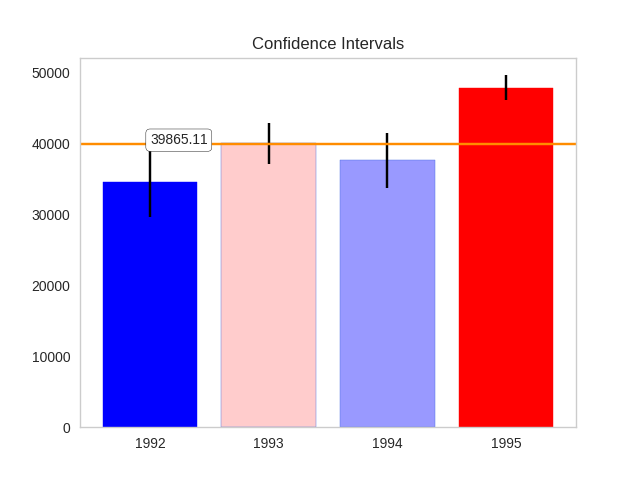

In [22]:
value = 42000
plotter(value)